# Molecular mass

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c

from scipy.optimize import curve_fit

In [15]:
rsun = 8.34 # kpc
rsun_err = 0.16 # kpc

vsun = 240 # km/s
vsun_err = 8 # km/s

omegasun = vsun/rsun # km/s/kpc

In [2]:
data = np.loadtxt('mcmc_files/molecular_mass_data.txt')

radius_list = data[:,0]
wco_list = data[:,1]
wco_err_list = data[:,2]

data2 = np.loadtxt('mcmc_files/rotcurve_data.txt')

vmax_list = data2[:,1] # subtracted off v_circ already
vmax_err_list = data2[:,2]

In [123]:
omega_list = [v/r for v,r in zip(vmax_list, radius_list)]
omega_err_list = [verr/r for verr,r in zip(vmax_err_list, radius_list)]

<ErrorbarContainer object of 3 artists>

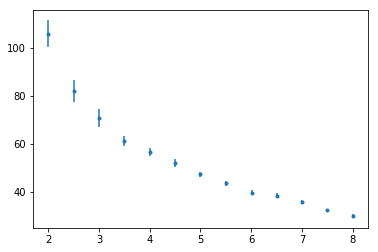

In [126]:
plt.errorbar(radius_list, omega_list, omega_err_list, fmt='.')

In [127]:
def omegafit(r, a, b):
    return a * r**(-b)

In [130]:
popt, pcov = curve_fit(omegafit, radius_list, omega_list, sigma=omega_err_list, p0=[100,2])
popt

array([188.36086022,   0.86689002])

In [148]:
import emcee

In [164]:
def logprob(x):
    #print(omegafit(2, *x))
    lp = -sum((omegafit(r, *x) - omega)**2/(2*omega_err**2) for r, omega, omega_err in zip(radius_list, omega_list, omega_err_list))
    lp += sum(np.log(1/np.sqrt(2*np.pi*sig**2)) for sig in omega_err_list)
    return lp

In [166]:
ndim = 2
nwalkers = 4

In [167]:
p0 = np.array([popt for _ in range(nwalkers)]) + 0.01 * np.random.randn(nwalkers, ndim)

In [168]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob)
state = sampler.run_mcmc(p0, 5000)

dim 0


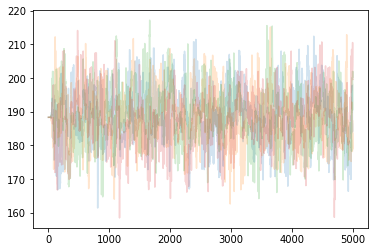

dim 1


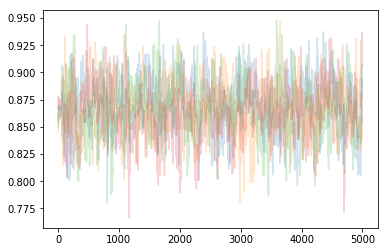

In [171]:
chain = sampler.get_chain()
for dim in range(ndim):
    print('dim', dim)
    for walker in range(nwalkers):
        plt.plot(abs(chain[:,walker,dim]), alpha=.2)
    plt.show()

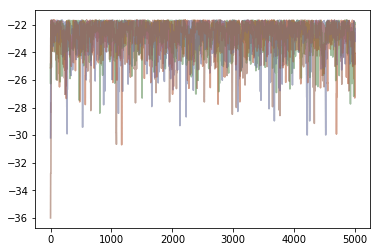

In [172]:
for walker in range(nwalkers):
    plt.plot(sampler.get_log_prob(), alpha=.2)

In [286]:
burnin = 1000
param_means = np.mean(chain[burnin:,:,:].reshape(-1,ndim), axis=0)
param_stds = np.std(chain[burnin:,:,:].reshape(-1,ndim), axis=0, ddof=1)

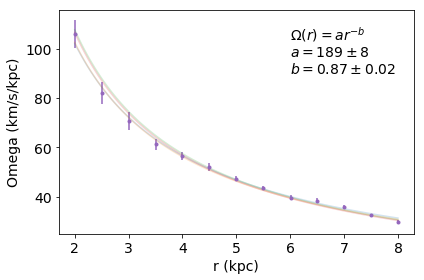

In [297]:
radii = np.linspace(2,8, 100)
for walker in range(nwalkers):
    x = chain[-1,walker,:]
    plt.plot(radii, [omegafit(r, *x) for r in radii], alpha=.2)
plt.errorbar(radius_list, omega_list, omega_err_list, fmt='.')
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Omega (km/s/kpc)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(6,90,'$\\Omega(r) = a r^{-b}$\n$a = %.0f \pm %.0f$\n$b = %.2f \pm %.2f$'%(param_means[0], param_stds[0], param_means[1], param_stds[1]), fontsize=14)
plt.tight_layout()
#plt.savefig('imgs/omegafit.png')

In [175]:
# radii = np.linspace(2,8,100)
# plt.errorbar(radius_list, omega_list, omega_err_list, fmt='.')
# plt.plot(radii, omegafit(radii, *popt))
# plt.ylabel('Omega (km/s/kpc)')
# plt.xlabel('r (kpc)')

In [176]:
omega_prime_list = [(vr-20)/(radius) for vr, radius in zip(vmax_list, radius_list)]

In [177]:
from scipy.optimize import fsolve

In [178]:
def omega(r):
    return omegafit(r,*popt)
fsolve(lambda r: omega(r)-30, 8)

array([8.32494459])

In [181]:
chain.shape

(5000, 4, 2)

In [182]:
x_chain = chain[-5:].reshape(-1,ndim)

In [194]:
wco_length_list_list = []
for param_instance in x_chain:
    r_prime_list = [fsolve(lambda r: omegafit(r, *param_instance)-omega_prime, rad)[0] for omega_prime, rad in zip(omega_prime_list, radius_list)]
    wco_length_list = [2*np.sqrt(rp**2-r**2) for r,rp in zip(radius_list, r_prime_list)]
    wco_length_list_list.append(wco_length_list)
wco_length_list_list = np.array(wco_length_list_list)

In [199]:
np.mean(wco_length_list_list, axis=0)

array([8.79033901, 7.07111858, 4.66939452, 4.25955746, 5.55453774,
       4.53254578, 4.20641201, 3.76219458, 3.8880124 , 4.23013598,
       3.52560556, 3.13270724, 1.79114741])

In [200]:
np.std(wco_length_list_list, axis=0, ddof=1)

array([0.75558611, 0.6547869 , 0.62548871, 0.50101092, 0.34133065,
       0.29285632, 0.26720713, 0.28298044, 0.27052393, 0.24548898,
       0.28371916, 0.29125823, 0.40014755])

In [75]:
x_factor = 2.7e20 # error?

In [82]:
(1*u.kpc/u.cm).si

<Quantity 3.08567758e+21>

In [207]:
wco_length_list = np.mean(wco_length_list_list, axis=0)
wco_length_cm_list = wco_length_list * (1*u.kpc/u.cm).si

wco_length_err_list = np.std(wco_length_list_list, axis=0, ddof=1)
wco_length_err_cm_list = wco_length_err_list * (1*u.kpc/u.cm).si

In [224]:
# num_dens_h2
num_dens_h2_list = x_factor * wco_list / wco_length_cm_list
quadrature_err_list = np.sqrt((wco_err_list/wco_list)**2+(wco_length_err_list/wco_length_list)**2)

num_dens_h2_err_list = num_dens_h2_list * quadrature_err_list

<ErrorbarContainer object of 3 artists>

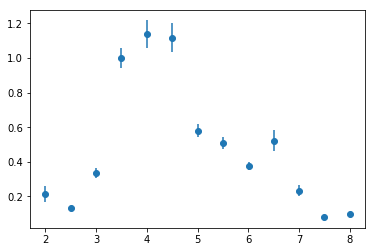

In [225]:
plt.errorbar(radius_list, num_dens_h2_list, num_dens_h2_err_list, fmt='o') # per cm^3

In [226]:
mass_h2 = 2*8.35e-58 # solar masses

In [260]:
#disk_width_deg = np.sqrt(2*np.pi) * (37.56430858* 0.20888485+9.76525117* 0.73162962)/(37.56430858+9.76525117)
disk_width_deg = np.sqrt(2*np.pi)*0.2094586476998572# deg # * .27820271 
disk_width_deg_err = np.sqrt(2*np.pi)*0.00397215 # deg
disk_width = rsun*np.cos(32.65*np.pi/180)*disk_width_deg*np.pi/180
disk_width_err = rsun*np.cos(32.65*np.pi/180)*disk_width_deg_err*np.pi/180
surface_density_list = np.array([n*disk_width*mass_h2 for n in num_dens_h2_list]) * (1*u.kpc/u.cm**3).to(u.pc**-2).value
surface_density_err_list = surface_density_list * np.sqrt(quadrature_err_list**2 + (disk_width_err/disk_width)**2)

In [263]:
rsun*np.cos(32.65*np.pi/180)*np.pi/180 * 1.25

0.15319909227469303

In [261]:
disk_width * 2.355 / np.sqrt(2*np.pi)

0.06045543992858815

In [259]:
150/90

1.6666666666666667

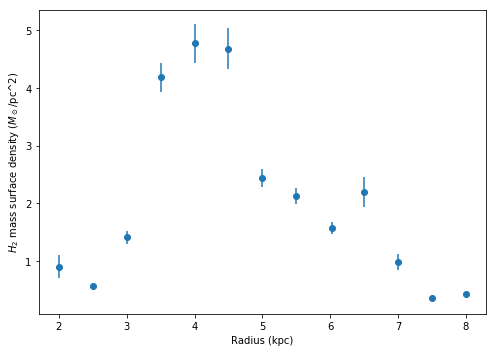

In [245]:
plt.figure(figsize=(7,5))
plt.errorbar(radius_list, surface_density_list, surface_density_err_list, fmt='o') # msun / pc^2
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$H_2$ mass surface density ($M_\odot$/pc^2)')
plt.tight_layout()

In [246]:
published_data_2gauss = np.array([[2.6600,3.5000 ],
[3.7200,3.5000 ],
[4.7800,4.6000 ],
[5.8400,3.9000 ],
[6.9100,2.8000 ],
[7.9700,1.9000 ],
[9.0300,0.90000],
[10.090,0.50000],
[11.160,0.30000]])

published_data_axisymmetric = np.array([[1.9100, 1.0400],
[2.3400, 1.3600],
[2.7600, 1.2900],
[3.1900, 2.2900],
[3.6100, 4.1800],
[4.0400, 4.3600],
[4.4600, 5.3900],
[4.8900, 4.8600],
[5.3100, 4.3600],
[5.7400, 3.3200],
[6.1600, 3.5400],
[6.5900, 3.7100],
[7.0100, 2.6400],
[7.4400, 1.6100],
[7.8600, 1.0700]])

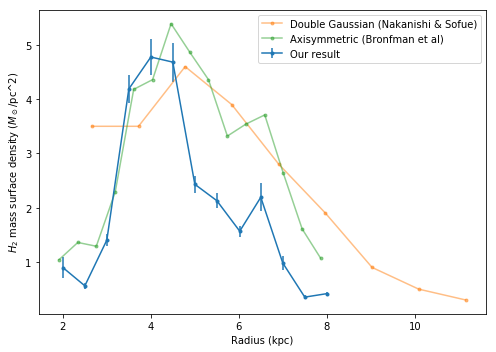

In [247]:
plt.figure(figsize=(7,5))
plt.errorbar(radius_list, surface_density_list, surface_density_err_list, fmt='.-', label='Our result') # msun / pc^2
plt.plot(published_data_2gauss[:,0], published_data_2gauss[:,1], '.-', alpha=.5, label='Double Gaussian (Nakanishi & Sofue)')
plt.plot(published_data_axisymmetric[:,0], published_data_axisymmetric[:,1], '.-', alpha=.5, label='Axisymmetric (Bronfman et al)')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$H_2$ mass surface density ($M_\odot$/pc^2)')
plt.tight_layout()
plt.legend()
plt.savefig('imgs/newplot.png')

In [264]:
dr = 0.5 # kpc
annulus_mass_list = np.array([2*np.pi*r * dr * surface_density
                              for r, surface_density in zip(radius_list, surface_density_list)]) * (1*u.kpc/(1*u.pc)).si**2
annulus_mass_err_list = np.array([2*np.pi*r * dr * surface_density_err
                                  for r, surface_density_err in zip(radius_list, surface_density_err_list)]) * (1*u.kpc/(1*u.pc)).si**2

<ErrorbarContainer object of 3 artists>

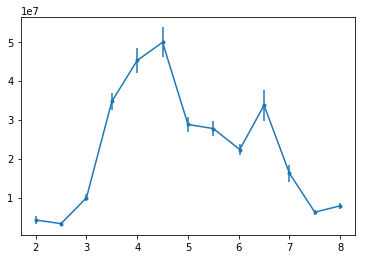

In [267]:
plt.errorbar(radius_list, annulus_mass_list, annulus_mass_err_list, fmt='.-')

In [268]:
sum(annulus_mass_list)

<Quantity 2.90083963e+08>

In [270]:
'%g'%np.sqrt(sum(annulus_mass_err_list**2))

'7.93357e+06'

In [274]:
published_data_axisymmetric[1:,0] - published_data_axisymmetric[:-1,0]

array([0.43, 0.42, 0.43, 0.42, 0.43, 0.42, 0.43, 0.42, 0.43, 0.42, 0.43,
       0.42, 0.43, 0.42])

In [276]:
np.sum(2*np.pi*published_data_axisymmetric[:,0]*.43*published_data_axisymmetric[:,1] * (1*u.kpc/(1*u.pc)).si**2)

<Quantity 6.04931635e+08>